In [1]:
import pickle
import re 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter
import os

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Analysis of detected lick times

In [2]:
#load data and extract lick times

# path = r"U:\Data\zimmer94\Behavior_rigs\licks\03.20.21\CC077837_HP1_pav_2021-03-20_13-29-26.pkl"
path = r"U:\Data\zimmer94\Behavior_rigs\licks\03.30.21\CC077837_HP1_oper_2021-03-30_13-40-26.pkl"

f=open(path, 'rb')
objs = []
while 1:
    try:
        objs.append(pickle.load(f))
    except EOFError:
        break
f.close()


In [3]:
CC_num = path.split("\\")[-1].split("_")[0]
HP_num = path.split("\\")[-1].split("_")[1]
mouse = str(CC_num + ' ' + HP_num)
print('Mouse:', mouse)

paradigm = path.split("\\")[-1].split("_")[2]
print('Paradigm:', paradigm)

if paradigm == 'pav':
    stim_lb = 0.0 #lower bound of stimulus time
    stim_ub = 1.0 #upper bound of stimulus time
    rew_lb = 1.0
    rew_ub = 1.2
    stim_dur = 1.0
elif paradigm == 'inter':
    stim_lb = 0.0 #lower bound of stimulus time
    stim_ub = 0.2 #upper bound of stimulus time
    rew_lb = 0.7
    rew_ub = 0.9
    stim_dur = 0.2


Mouse: CC077837 HP1
Paradigm: oper


In [4]:
#extracting the start of water delivery ('r')
rew_time_ls = [x.split("r")[1].split(" ")[0].split("u")[0] for x in objs]

#converting the string to to an array
rew_time_ar = np.array(rew_time_ls, dtype=np.float32)
rew_time_ar = rew_time_ar

#subtracting the stimulus duration
stim_times = rew_time_ar - stim_dur
#stim_times #start times of the stimulus - this is our 0 time point


IndexError: list index out of range

In [5]:
#removing the 'u' and 'r' identifiers
cleaned_objs = [ x.replace('u', ' ') for x in objs if 'u' in x ]
cleaned_objs = [ x.replace('r',' ') for x in cleaned_objs if 'r' in x ]

lick_times = [np.array(x.strip().split(" "), dtype=np.float32) for x in cleaned_objs ]


In [15]:
for idx, val in enumerate(rew_time_ar):
    lick_times[idx] =  lick_times[idx][lick_times[idx] != val]

In [16]:
df_licks = pd.DataFrame(lick_times).sub(stim_times, axis = 0)

# remove the first stimulus because of the massive delay present in the recording
# its the delay used to position the delivery so that the mouse doesn't get the massive flow
df_licks.drop(df_licks.index[0], inplace=True)

df_licks2 = pd.DataFrame(df_licks.stack())

print(df_licks.shape)
print(df_licks2.shape)


(149, 64)
(2493, 1)


# Plotting the licks across trials

In [24]:
df_licks2 = df_licks2.reset_index()
df_licks2.columns = ["trial", "lick_idx", "lick_time"]

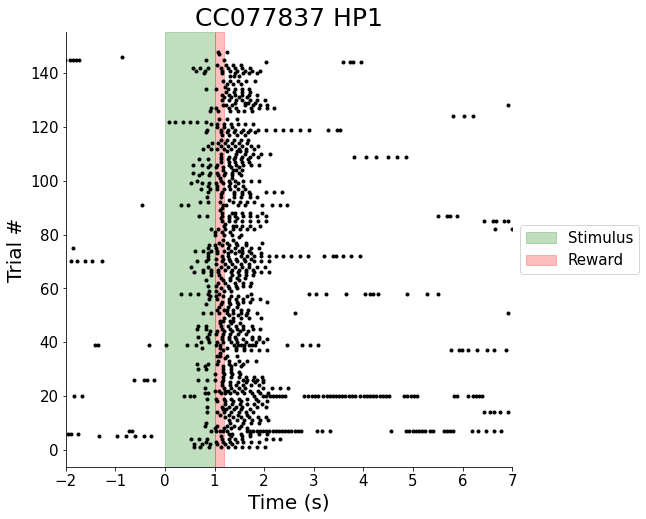

In [25]:
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 8.0 # x dimension
fig_size[1] = 8.0 # y dimension
plt.plot( df_licks2.lick_time.values, df_licks2.trial, 'k.', label='_nolegend_')
sns.despine()

plt.xlim(-2, 7)
plt.axvspan(stim_lb,stim_ub, color='green', alpha=0.25)
plt.axvspan(rew_lb, rew_ub, color='red', alpha=0.25) 

plt.title(mouse,fontsize=25)
plt.xlabel('Time (s)',fontsize=20)
plt.ylabel('Trial #',fontsize=20)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(('Stimulus','Reward'),loc='center left', bbox_to_anchor=(1,0.5), prop={'size': 15})

# Change the end of this next line with a new file name!!
#plt.savefig(r"C:\Users\AChub_Lab\Desktop\zimmer94\Data\DATA_Figs\Behavior\CC077877_HP1_0320_trials.pdf", transparent=True)

# Plotting the histogram
This is licks across all trials for the day

(-2.0, 6.0)

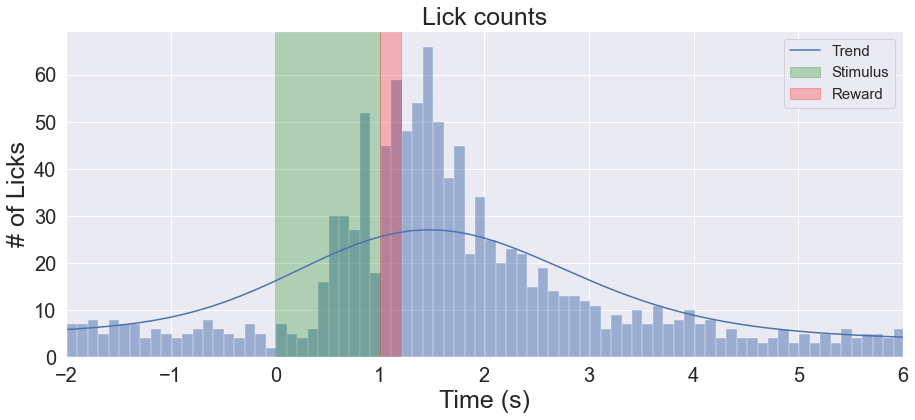

In [34]:
sns.set(rc={'figure.figsize':(15,6)})
hist = sns.histplot(df_licks2.lick_time.values, binwidth=0.1, kde=True, legend=False)

hist.set(xlabel="Lick time (s)", ylabel="Number of licks")
plt.axvspan(stim_lb,stim_ub, color='green', alpha=0.25)
plt.axvspan(rew_lb, rew_ub, color='red', alpha=0.25) 
plt.legend(('Trend','Stimulus','Reward'), prop={'size': 15})
#plt.suptitle(mouse, fontsize=20)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.title("Lick counts", fontsize=25)
plt.xlabel("Time (s)", fontsize=25)
plt.ylabel('# of Licks', fontsize=25)
plt.xlim(-2, 6)


# Change the end of this next line with a new file name!!
#plt.savefig(r"C:\Users\AChub_Lab\Desktop\zimmer94\Data\DATA_Figs\Behavior\CC077877_HP1_0320_hist.pdf", transparent=True)

(-2.0, 6.0)

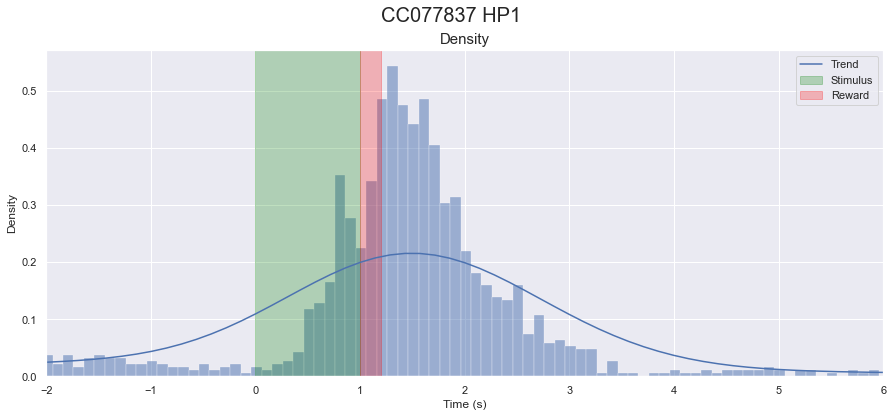

In [11]:
sns.set(rc={'figure.figsize':(15,6)})
hist = sns.histplot(df_licks2.lick_time.values, binwidth=0.1, kde=True, legend=False, stat="density")

hist.set(xlabel="Lick time (s)", ylabel="Density")
plt.axvspan(stim_lb,stim_ub, color='green', alpha=0.25)
plt.axvspan(rew_lb, rew_ub, color='red', alpha=0.25) 
plt.legend(('Trend','Stimulus','Reward'))
plt.suptitle(mouse, fontsize=20)
plt.title("Density", fontsize=15)
plt.xlabel("Time (s)")
plt.xlim(-2, 6)




*****

_____

# Plotting licks over days
Gives heatmap of the normalized licks/day across all training sessions

### First, we create a function to load and store data

In [4]:
#load data and extract lick times
def get_licks_df(path):
    stim_dur = 1
    f=open(path, 'rb')
    objs = []
    while 1:
        try:
            objs.append(pickle.load(f))
        except:
            break
    f.close()

    #extracting the start of water delivery ('r')
    rew_time_ls = [x.split("r")[1].split(" ")[0].split("u")[0] for x in objs]

    #converting the string to to an array
    rew_time_ar = np.array(rew_time_ls, dtype=np.float32)
    rew_time_ar = rew_time_ar

    #subtracting the stimulus duration
    stim_times = rew_time_ar - stim_dur
    stim_times #start times of the stimulus - this is our 0 time point

    #removing the 'u' and 'r' identifiers
    cleaned_objs = [ x.replace('u', ' ') for x in objs if 'u' in x ]
    cleaned_objs = [ x.replace('r',' ') for x in cleaned_objs if 'r' in x ]

    lick_times = [np.array(x.strip().split(" "), dtype=np.float32) for x in cleaned_objs ]

    for idx, val in enumerate(rew_time_ar):
        lick_times[idx] =  lick_times[idx][lick_times[idx] != val]

    df_licks = pd.DataFrame(lick_times).sub(stim_times, axis = 0)

    # remove the first stimulus because of the massive delay present in the recording
    # its the delay used to position the delivery so that the mouse doesn't get the massive flow
    df_licks.drop(df_licks.index[0], inplace=True)

    df_licks2 = pd.DataFrame(df_licks.stack())
    return df_licks2

### Now we load and work with the data

In [24]:
# load data
path = r"U:\Data\zimmer94\Behavior_rigs\licks\04.04.21\CC077837_HP1_oper_2021-04-02_15-23-1....pkl"

# paradigm = "inter"
paradigm = "pav"

matches = []
for root, dirnames, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith(('.pkl')) and paradigm in filename and "mouse" not in filename and "bad" not in filename:
            matches.append(os.path.join(root, filename))
print ("# of file matches:", len(matches))

matches[0]

# of file matches: 0


IndexError: list index out of range

In [7]:
# taking the loaded files and creating a df from them
bins = np.arange(-2, 6.1, 0.1).round(3)
ls = []
for fn in matches[:]:
    try:
        tmp =  get_licks_df(fn)
        base = fn.split("\\")[-1]
        CC = base.split("_")[0]
        hp_n =  base.split("_")[1]
        paradigm = base.split('_')[2]
        counts, bins = np.histogram(tmp.values, bins = bins)
        dt = base.split('_')[-2]
        tmp_df = pd.DataFrame({"et": str(CC) + str(hp_n), 
                               "paradigm":paradigm, 
                               "lick_counts":counts, 
                               "bins":bins[:-1], 
                               "session": dt})
        ls.append(tmp_df)
    except:
        print ("not loaded:", fn)

main_df = pd.concat(ls)

not loaded: U:\Data\zimmer94\Behavior_rigs\licks\03.03.21\CC078076_HP1_pav_2021-03-03_17-14-01.pkl
not loaded: U:\Data\zimmer94\Behavior_rigs\licks\03.03.21\CC078076_HP2_pav_2021-03-03_17-14-01.pkl
not loaded: U:\Data\zimmer94\Behavior_rigs\licks\03.16.21\CC078076_HP2_pav_2021-03-16_16-29-27.pkl


In [8]:
main_df['session']= pd.to_datetime(main_df['session'])

print("Number of mice in this paradigm:",main_df['et'].nunique(), "\n")
print("Unique ET:", main_df['et'].unique())

#main_df.head(5)

Number of mice in this paradigm: 3 

Unique ET: ['CC077837HP1' 'CC078076HP1' 'CC078076HP2']


In [9]:
sns.set_context("poster")
plt.rcParams["figure.figsize"] = (10, 10)
plt.rcParams["font.size"] = 1.5

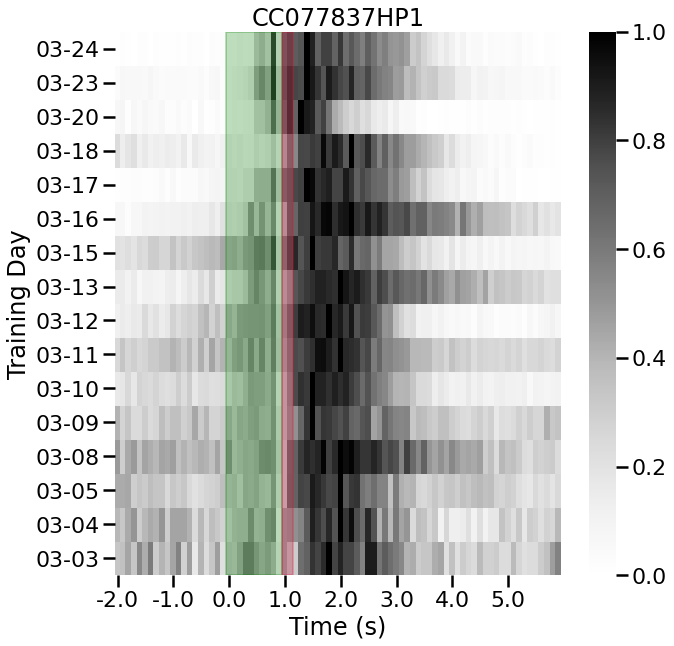

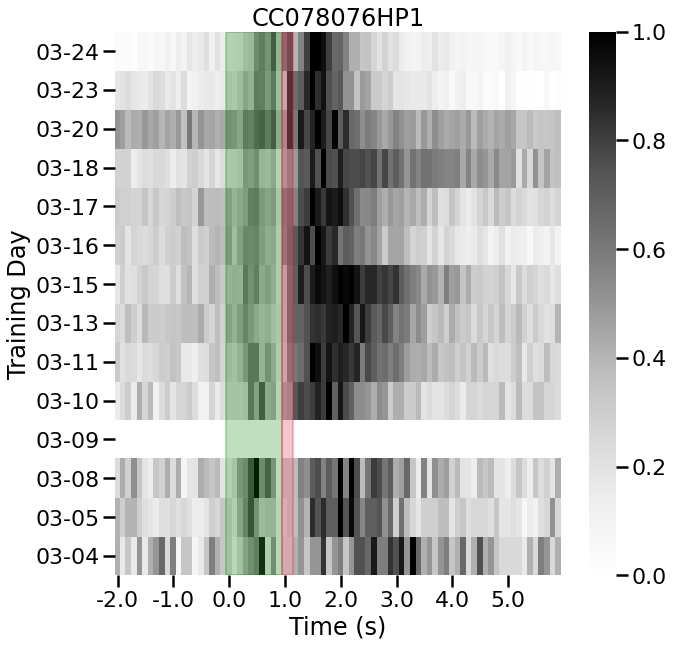

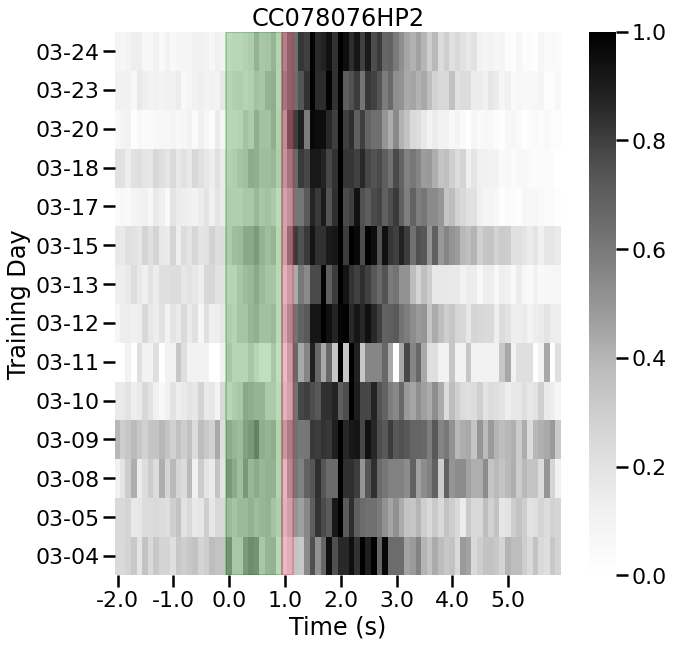

In [13]:
for et in main_df.et.unique():
    tmp = main_df[main_df.et == et]
    hm_inp = tmp.pivot('session', 'bins', 'lick_counts') #this is the heatmap input
    max_ar = hm_inp.max(axis = 1).values
    hm_inp = hm_inp.div(max_ar, axis = 0)
    sns.heatmap(hm_inp, cmap = "Greys", xticklabels=10, yticklabels = tmp.session.dt.strftime('%m-%d').unique())

    plt.title(et)
    plt.gca().invert_yaxis()
    plt.xlabel('Time (s)')
    plt.ylabel('Training Day')
    
    if paradigm == "inter":
        plt.axvspan(20, 23, color = "green", alpha = 0.25)     #this is for interval training
        plt.axvspan(29, 31, color = "crimson", alpha = 0.25)   #this is for interval training
    elif paradigm == "pav":
        plt.axvspan(20, 30, color = "green", alpha = 0.25)     #this is for pav training
        plt.axvspan(30, 32, color = "crimson", alpha = 0.25)   #this is for pav training

    plt.show()

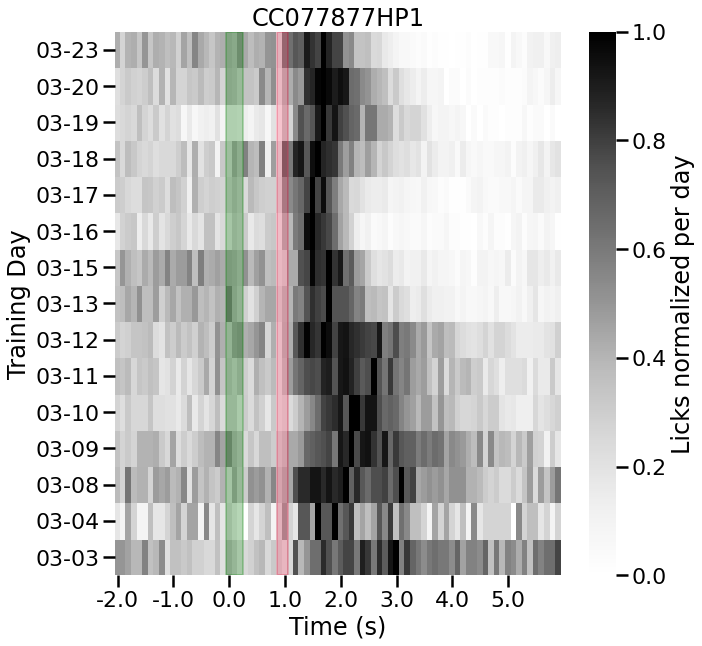

<Figure size 720x720 with 0 Axes>

In [23]:
et = "CC077877HP1"

tmp = main_df[main_df.et == et]
hm_inp = tmp.pivot('session', 'bins', 'lick_counts') #this is the heatmap input
max_ar = hm_inp.max(axis = 1).values
hm_inp = hm_inp.div(max_ar, axis = 0)
sns.heatmap(hm_inp, cmap = "Greys", 
            xticklabels=10, 
            yticklabels = tmp.session.dt.strftime('%m-%d').unique(),
            cbar_kws={'label': 'Licks normalized per day'})

plt.title(et)
plt.gca().invert_yaxis()
plt.xlabel('Time (s)')
plt.ylabel('Training Day')

if paradigm == "inter":
    plt.axvspan(20, 23, color = "green", alpha = 0.25)     #this is for interval training
    plt.axvspan(29, 31, color = "crimson", alpha = 0.25)   #this is for interval training
elif paradigm == "pav":
    plt.axvspan(20, 30, color = "green", alpha = 0.25)     #this is for pav training
    plt.axvspan(30, 32, color = "crimson", alpha = 0.25)   #this is for pav training

plt.show()


# Change the end of this next line with a new file name!!
plt.savefig(r"C:\Users\AChub_Lab\Desktop\zimmer94\Data\DATA_Figs\Behavior\CC077877_HP1_0320_days.pdf", transparent=True)

### Joyplot

In [209]:
sns.set_context("poster")
plt.rcParams["figure.figsize"] = (10, 10)
plt.rcParams["font.size"] = 22

In [2]:
import joypy

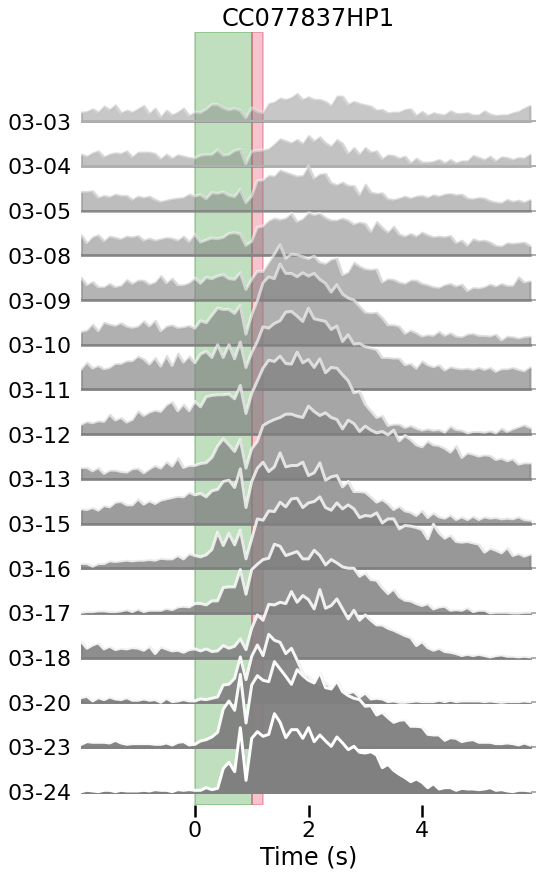

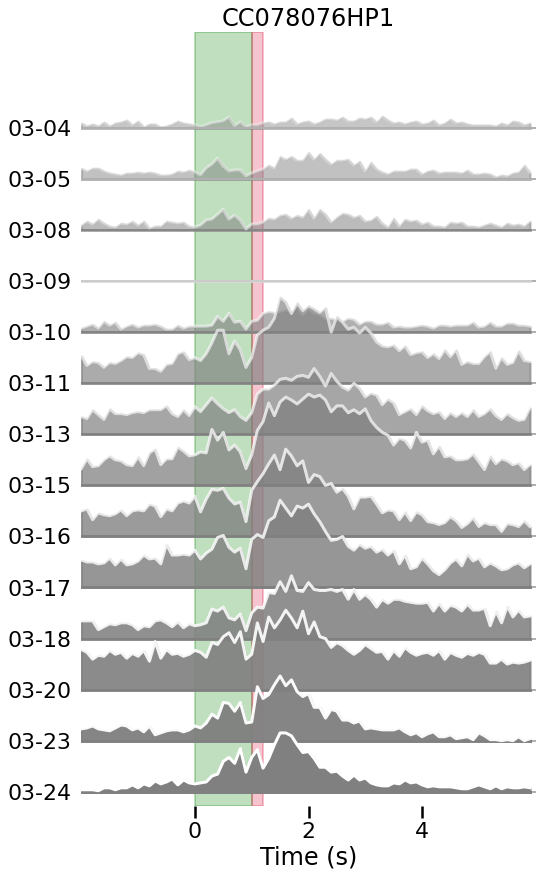

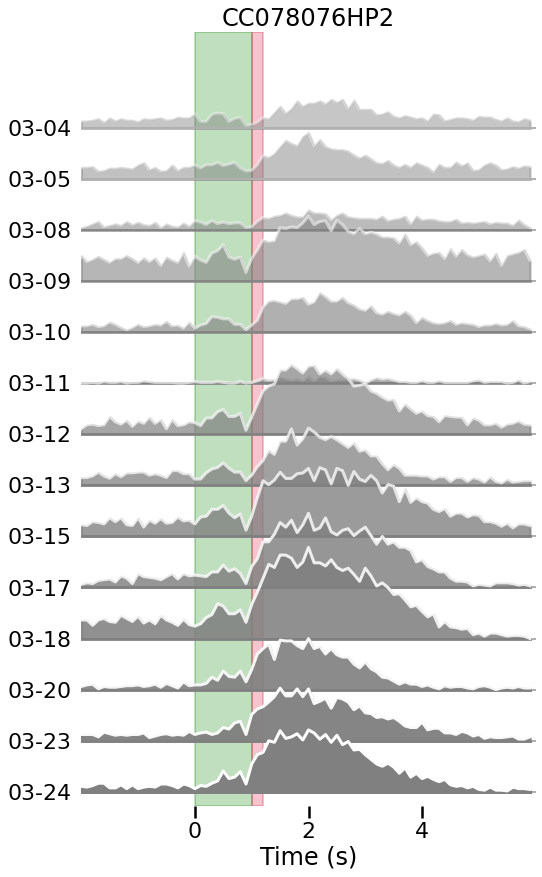

In [235]:

for et in main_df.et.unique():
    tmp = main_df[main_df.et == et]
    ylabels = tmp.session.dt.strftime('%m-%d').unique()
    fig, axes = joypy.joyplot(tmp, by = "session", column ='lick_counts' , 
                              labels = ylabels,
#                               ylim = "own",
                              kind = "values",
                              grid = 'y', 
                              fade = 1,
#                               xlabels = [1, 2,3 ],
                              figsize = (8, 12),
#                               bins = 100,
                              x_range = list(range(81)),
#                               colormap = plt.cm.Pastel1,
                              linecolor = "white", color = "gray",
                              overlap = 0.6
                             )
    axes[-1].set_xticklabels([0,2,4])
    axes[-1].set_title(et)
    axes[-1].set_xlabel("Time (s)")
    axes[-1].set_ylabel("Session")
    plt.axvspan(20, 30, color = "green", alpha = 0.25)     #this is for pav training
    plt.axvspan(30, 32, color = "crimson", alpha = 0.25)   #this is for pav training
#     plt.show()

In [41]:
data, grid, labels, sublabels, xlabels, xlabelsize, xrot, ylabelsize, yrot, ax, 
igsize, hist, bins, fade, xlim, ylim, fill, linecolor, overlap, background, range_style, 
x_range, tails, title, legend, loc, 
colormap, color, **kwargs)

['03-03',
 '03-04',
 '03-05',
 '03-08',
 '03-09',
 '03-10',
 '03-11',
 '03-12',
 '03-13',
 '03-15',
 '03-16',
 '03-17',
 '03-18',
 '03-20',
 '03-23',
 '03-24']

In [223]:
bins[40]

2.0

In [74]:
iris = pd.read_csv("iris.csv")

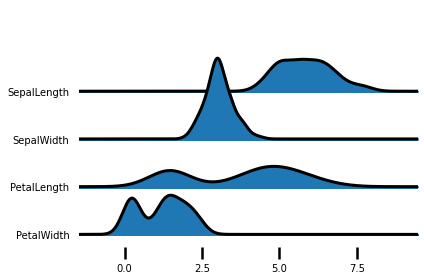

In [87]:
fig, axes = joypy.joyplot(iris)


### Analyzing operant conditioning data

In [158]:
#load data and extract lick times
path = r"U:\Data\zimmer94\Behavior\licks\04.07.21\CC078076_HP1_vis_disc_2021-04-07_12-14-57.pkl"

f=open(path, 'rb')
objs = []
while 1:
    try:
        objs.append(pickle.load(f))
    except EOFError:
        break
f.close()


In [159]:
CC_num = path.split("\\")[-1].split("_")[0]
HP_num = path.split("\\")[-1].split("_")[1]
mouse = str(CC_num + ' ' + HP_num)
print('Mouse:', mouse)

paradigm = path.split("\\")[-1].split("_")[2]
print('Paradigm:', paradigm)

if paradigm == 'pav' or paradigm == 'vis':
    stim_lb = 0.0 #lower bound of stimulus time
    stim_ub = 1.0 #upper bound of stimulus time
    rew_lb = 1.0
    rew_ub = 1.2
    stim_dur = 1.0

Mouse: CC078076 HP1
Paradigm: vis


In [160]:
#extracting the start of water delivery ('r')
rew_time_ls = []
for idx, val in enumerate(objs):
    if 'r' in objs[idx]:
        rew_time_ls.append(objs[idx].split("r")[1].split(" ")[0].split("u")[0])
    elif 'm' in objs[idx]:
        rew_time_ls.append(objs[idx].split("m")[1].split(" ")[0].split("u")[0])
    elif 'o' in objs[idx]:
        rew_time_ls.append(objs[idx].split("o")[1].split(" ")[0].split("u")[0])

#converting the string to to an array
rew_time_ar = np.array(rew_time_ls, dtype=np.float32)
rew_time_ar = rew_time_ar

#subtracting the stimulus duration
stim_times = rew_time_ar - stim_dur
#stim_times #start times of the stimulus - this is our 0 time point


In [161]:
stim_times.size

150

In [162]:
#removing the 'u' and 'r' identifiers
cleaned_objs = [ x.replace('u', ' ') for x in objs if 'u' in x ]
cleaned_objs2 = []
for idx, val in enumerate(cleaned_objs):
    if 'r' in cleaned_objs[idx]:
        cleaned_objs2.append(cleaned_objs[idx].replace('r',' '))
    elif 'm' in cleaned_objs[idx]:
        cleaned_objs2.append(cleaned_objs[idx].replace('m',' '))
    elif 'o' in cleaned_objs[idx]:
        cleaned_objs2.append(cleaned_objs[idx].replace('o',' '))

# cleaned_objs = [ x.replace('m',' ') for x in cleaned_objs if 'm' in x ]
lick_times = [np.array(x.strip().split(" "), dtype=np.float32) for x in cleaned_objs2 ]


In [163]:
for idx, val in enumerate(rew_time_ar):
    lick_times[idx] =  lick_times[idx][lick_times[idx] != val]

In [164]:
len(objs)

150

In [165]:
df_licks = pd.DataFrame(lick_times).sub(stim_times, axis = 0)

# remove the first stimulus because of the massive delay present in the recording
# its the delay used to position the delivery so that the mouse doesn't get the massive flow
df_licks.drop(df_licks.index[0], inplace=True)

df_licks2 = pd.DataFrame(df_licks.stack())

print(df_licks.shape)
print(df_licks2.shape)

(149, 151)
(4740, 1)


In [166]:
seq = [30, 150, 150, 30, 30, 150, 150, 30, 150, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 150, 30, 30, 30, 30, 30, 
       30, 150, 30, 30, 150, 150, 150, 30, 150, 30, 150, 150, 30, 150, 30, 30, 30, 30, 150, 150, 30, 150, 30, 150, 
       30, 30, 30, 30, 30, 150, 30, 30, 150, 150, 150, 30, 30, 30, 150, 150, 30, 30, 30, 30, 30, 30, 30, 30, 30, 150, 
       30, 150, 30, 30, 30, 30, 150, 30, 30, 30, 30, 150, 30, 150, 30, 150, 30, 30, 30, 30, 30, 30, 30, 30, 150, 30, 
       150, 150, 30, 30, 150, 30, 30, 30, 30, 150, 30, 30, 30, 150, 30, 30, 150, 30, 150, 150, 30, 150, 30, 150, 30, 
       30, 30, 30, 150, 30, 150, 30, 30, 30, 150, 30, 150, 30, 150, 30, 30, 150, 30, 30, 150, 30, 30, 150, 150]
trials = np.arange(1, 151)
d_seq = dict(zip(trials, seq))

In [167]:
df_licks2 = df_licks2.reset_index()
df_licks2.columns = ["trial", "lick_idx", "lick_time"]
df_licks2['stim'] = df_licks2.trial.map(d_seq)

In [168]:
orig_trials = df_licks2.sort_values(by = ['stim', 'trial']).trial.unique()
rew_trials = np.arange(1, orig_trials.size + 1)
d_rew_trials = dict(zip(orig_trials, rew_trials))
df_licks2['rew_trials'] = df_licks2.trial.map(d_rew_trials)

In [169]:
df_licks2.groupby(['stim']).trial.nunique()

stim
30     94
150    44
Name: trial, dtype: int64

#### Plotting rewarded vs unrewarded trials

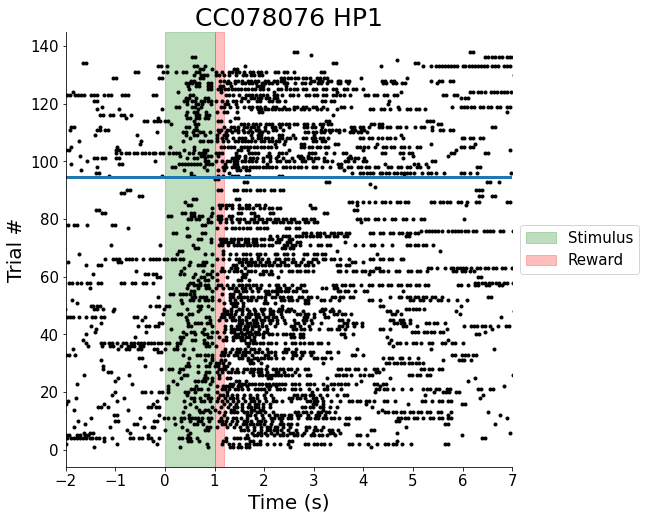

In [170]:
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 8.0 # x dimension
fig_size[1] = 8.0 # y dimension
plt.plot( df_licks2.lick_time.values, df_licks2.rew_trials, 'k.', label='_nolegend_')
sns.despine()

plt.xlim(-2, 7)
plt.axvspan(stim_lb,stim_ub, color='green', alpha=0.25)
plt.axvspan(rew_lb, rew_ub, color='red', alpha=0.25) 

plt.title(mouse,fontsize=25)
plt.xlabel('Time (s)',fontsize=20)
plt.ylabel('Trial #',fontsize=20)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(('Stimulus','Reward'),loc='center left', bbox_to_anchor=(1,0.5), prop={'size': 15})

trial_cut = df_licks2[df_licks2.stim == 30].rew_trials.max()
plt.axhline(y = trial_cut + 0.5, linewidth = 3)
# Change the end of this next line with a new file name!!
#plt.savefig(r"C:\Users\AChub_Lab\Desktop\zimmer94\Data\DATA_Figs\Behavior\CC077877_HP1_0320_trials.pdf", transparent=True)

96